In [1]:
# Enable interactive rotation of graph
%matplotlib notebook

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Load data for activity
X = np.loadtxt('sdata.csv',delimiter=',')

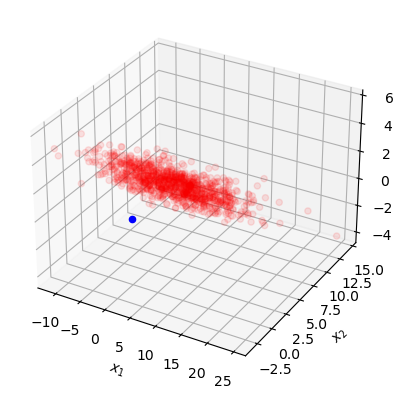

In [2]:
%matplotlib inLine

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c='r', marker='o', alpha=0.1)
ax.scatter(0,0,0,c='b', marker='o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')

plt.show()

### 2a) 
It does not lay in the low dimensional space because it does contain the origin. The space is a 3D plane where the data lies along a plane it looks like.

## 2b)
You could use methods like PCA and center the data (done below) so it contains the origin.

In [3]:
# Subtract mean
X_m = X - np.mean(X, 0)

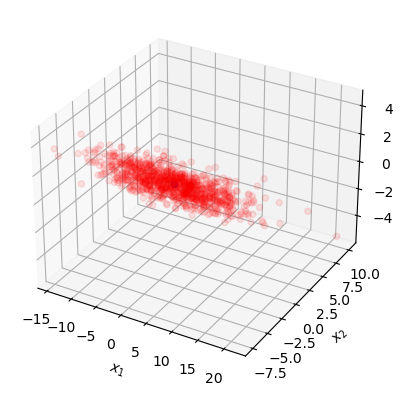

In [4]:
# display zero mean scatter plot
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_m[:,0], X_m[:,1], X_m[:,2], c='r', marker='o', alpha=0.1)

ax.scatter(0,0,0,c='b', marker='o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')

plt.show()

## 2c)
Yes, the mean-removed data appears to lie in a low dimensional sub-space. The data now looks like it contains the origin, so this subspace would fit/hold the data.

## 2d)
The line below goes in the direction of where the most varience is. It seems to fit the data very well.

In [7]:
# Use SVD to find first principal component

U,s,VT = np.linalg.svd(X_m,full_matrices=False)

# complete the next line of code to assign the first principal component to a
a = VT.transpose()[:, 0]

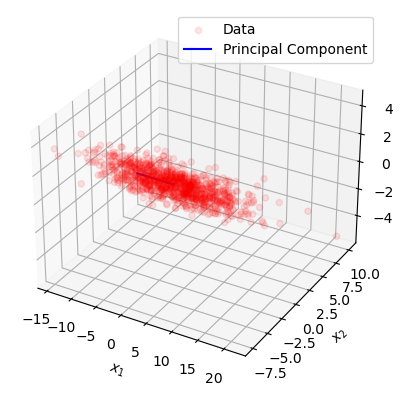

In [9]:
# display zero mean scatter plot and first principal component

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#scale length of line by root mean square of data for display
ss = s[0]/np.sqrt(np.shape(X_m)[0])

ax.scatter(X_m[:,0], X_m[:,1], X_m[:,2], c='r', marker='o', label='Data', alpha=0.1)

ax.plot([0,ss*a[0]],[0,ss*a[1]],[0,ss*a[2]], c='b',label='Principal Component')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')


ax.legend()
plt.show()

## 2h & i)

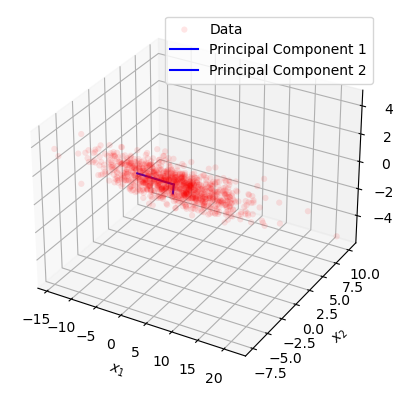

In [28]:
U, s, VT = np.linalg.svd(X_m, full_matrices=False)

# First two principal components to a
a = VT.transpose()[:, :2]

# display zero mean scatter plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#scale length of line by root mean square of data for display
ss = s[:2] / np.sqrt(np.shape(X_m)[0])

# Plot scatter points with transparency kinda
ax.scatter(X_m[:, 0], X_m[:, 1], X_m[:, 2], c='r', marker='o', label='Data', alpha=0.1, edgecolors='none',zorder=2)

for i in range(2):
    ax.plot([0, ss[i] * a[0, i]], [0, ss[i] * a[1, i]], [0, ss[i] * a[2, i]], c='b', label=f'Principal Component {i + 1}', zorder=1)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')

ax.legend()
plt.show()


## 2k)

In [29]:
#rank 1 approx Frobenius norm as written on my pdf above is the difference between the true x and rank1's
#sigma values squared which leaves us with s from USVT_2 and USVT_3 
frobenius_norm_rank_one = s[1]**2 + s[2]**2
#rank2 approx Frobenius norm is just equal to the sigma3 value squared
frobenius_norm_rank_two = s[2]**2

print(frobenius_norm_rank_one)
print(frobenius_norm_rank_two)
#rank 2 approx is less than rank 1 approx

25.033775591913372
12.367116712429965


## 3a)

In [64]:
from scipy.io import loadmat
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error

data = loadmat('face_emotion_data.mat')
X = data['X']
y = data['y']

def truncated_svd_regression(X_train, y_train, X_test, r):
    U, s, Vt = svd(X_train, full_matrices=False)
    U_r = U[:, :r]
    S_inv_r = np.diag(1 / s[:r])
    Vt_r = Vt[:r, :]
    X_pseudo = Vt_r.T @ S_inv_r @ U_r.T
    w = X_pseudo @ y_train
    y_pred = X_test @ w
    return y_pred

errors_svd = []

avg_error = 0
for i in range(8):
    for j in range(8):
        if i==j: 
            continue
        X_train = np.vstack([part for idx, part in enumerate(np.array_split(X, 8)) if idx not in [i,j]])
        y_train = np.vstack([part for idx, part in enumerate(np.array_split(y, 8)) if idx not in [i,j]])
        X_val = np.array_split(X, 8)[i]
        y_val = np.array_split(y, 8)[i]
        X_test = np.array_split(X, 8)[j]
        y_test = np.array_split(y, 8)[j]
        
        for r in range(1, 10): 
            y_pred_val = truncated_svd_regression(X_train, y_train, X_val, r)
            error = mean_squared_error(y_val, y_pred_val)
            if error < avg_error or avg_error == 0: 
                avg_error = error
                best_r = r
            
    y_pred_test = truncated_svd_regression(X_train, y_train, X_test, best_r)
    test_error = mean_squared_error(y_test, y_pred_test)
    errors_svd.append(test_error)
    
avg_svd_error = np.mean(errors_svd)
avg_svd_error

0.3021119808475197

## 3b)

In [67]:
from sklearn.linear_model import Ridge

lambdas = [2**i for i in [-1, 0, 1, 2, 3, 4]] 
errors_ridge = []
avg_error = 0
for i in range(8):
    for j in range(8):
        if i==j: 
            continue
        X_train = np.vstack([part for idx, part in enumerate(np.array_split(X, 8)) if idx not in [i,j]])
        y_train = np.vstack([part for idx, part in enumerate(np. array_split(y, 8)) if idx not in [i,j]])
        X_val = np.array_split(X, 8)[i]
        y_val = np.array_split(y, 8)[i]
        X_test = np.array_split(X, 8)[j]
        y_test = np.array_split(y, 8)[j]
        for lam in lambdas:
            ridge = Ridge(alpha=lam)
            ridge.fit(X_train, y_train)
            y_pred_val = ridge.predict(X_val)
            error = mean_squared_error(y_val, y_pred_val)

            if error < avg_error or avg_error == 0: 
                avg_error = error
                best_lambda = lam

ridge = Ridge(alpha=best_lambda)
ridge.fit(X_train, y_train)
y_pred_test = ridge.predict(X_test)
test_error = mean_squared_error(y_test, y_pred_test)
errors_ridge.append(test_error)
    
avg_ridge_error = np.mean(errors_ridge)
avg_ridge_error

0.14281929993989312

In [57]:
#We can see ridge regression has a lower error value than svd does